# Implement a 1D Plug Flow Reactor Model with Surface Chemistry

In this model, we will illustrate the derivation of the governing differential equations and algebraic constraints, calculation of the initial conditions of the variables and their primes and use the [scipy.odes.dae](http://scikits-odes.readthedocs.io/en/latest/guide.html#object-oriented-interface-ode-and-dae) IDA solver to solve this differential and algebraic equations (DAE).

In [1]:
from __future__ import print_function, division
from scipy.optimize import fsolve #to get the initial value of vecp0
import numpy as np
from scikits.odes import dae
import cantera as ct
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import prettyplotlib as ppl
from prettyplotlib import brewer2mpl
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.family'] = 'Times New Roman'
colors = brewer2mpl.get_map('Set2','qualitative',8).mpl_colors
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.3.0


## Define gas species, bulk species, surface species and the interface

Here, we use a kinetic mechanism involving the chemical vapor deposition of silicon nitride (Si3N4) from SiF4 and NH3. 25 gas species, 6 surface species and 2 bulk species mechanism is applied by [Richard S. Larson et al. 1996, SAND96-8211](https://github.com/yuj056/yuj056.github.io/blob/master/_posts/Sandia.pdf).

In [2]:
#import the SiF4 + NH3 reaction mechnism
mech ='/Users/yuanjie/Dropbox/Cantera_intern/code/gas_surf_phase/gas_surf_bulk/mec.cti'
#import the models for gas and bulk
ct.suppress_thermo_warnings()
gas, bulk_Si, bulk_N = ct.import_phases(mech,['gas','SiBulk','NBulk',])
#import the model for gas-Si-N interface
gas_Si_N_interface = ct.Interface(mech, 'SI3N4',[gas,bulk_Si,bulk_N])

# Case 1: isothermal reactor
## Define reactor conditions : temperature, pressure, fuel, and some important parameters

In [3]:
T = 1713 # Kelvin
p = 2 * ct.one_atm / 760.0 #Pa ~2Torr
gas.TPX = T,p,"NH3:6, SiF4:1"
bulk_Si.TP = T,p
bulk_N.TP = T,p
gas_Si_N_interface.TP = T,p
D = 5.08 * 10**-2 # diameter of the tube [m]
Ac = np.pi * D**2/4 # cross section of the tube [m^@]
Vdot = 588 * 10**-6/60 # volumetric rate [m^3/s]
mu = 5.7E-5 #kg/(m s) dynamic viscosity
perim = np.pi * D #perimeter of the tube
sigma_k = [2, 2, 2, 2, 4, 2] #site fraction of surface species as the same order of CTI file
#calculate the site fractions of surface species at the entrance of the tube at steady state
gas_Si_N_interface.advance_coverages(100.0) #Here we assume after 100s, the system reaches the steady state
Zk_0 = gas_Si_N_interface.coverages

## Define a residual function for IDA solver

For the isothermal tube with laminar flow, since the temperature of the flow and tube keeps constant the energy conservation equation can be blocked. The governing equations and constraints are listed as follows:
\begin{align}
    residual[0] &= u\frac{d\rho}{dz} + \rho\frac{du}{dz} - \frac{p'}{A_c}\sum^{K_g}\dot{s_k}W_k \\
    residual[1] &= \rho u A_c\frac{dY_k}{dz} + Y_k p'\sum^{K_g}\dot{s_k}W_k - \dot{\omega_k}W_kA_c - \dot{s_k}W_k p' \\
    residual[2] &= 2\rho u \frac{du}{dz} + u^2\frac{d\rho}{dz} + \frac{dP}{dz} + \frac{32u\mu}{D^2}\\
    residual[3] &= P\bar{W} - \rho RT\\                                                
    residual[4] &= \dot{s_k} ~~~\text{at steady state for 1 to $K_s$ - 1 species}\\                 
    residual[5] &= \sum_{phase}{Z_k} - 1 
\end{align}                                    
The detailed derivation of the DAE system can be found in [my report](https://github.com/yuj056/yuj056.github.io/blob/master/Week1/yuj056_github_io.pdf).

In [4]:
def residual(z, vec, vecp, result):
    """ we create the residual equations for the problem
        vec = [u, rho, Yk, p, Zk]
    """
    #unnorimalized the mass fraction to avoid over-constrained
    gas.set_unnormalized_mass_fractions(vec[2:2+gas.n_species])
    gas.TP = T,vec[2+gas.n_species]
    
    bulk_Si.TP = T,vec[2+gas.n_species]
    bulk_N.TP = T,vec[2+gas.n_species]
    #unnormalized the site fraction (coverages) to avoid over-constrained
    gas_Si_N_interface.set_unnormalized_coverages(vec[3+gas.n_species:])
    gas_Si_N_interface.TP = T,vec[2+gas.n_species]
       
    #mass continuity equation
    result[0] = vec[0]*vecp[1]+vec[1]*vecp[0]-perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)/Ac
    #conservation of species
    for k in range(gas.n_species):
        result[1+k] = vec[1]*vec[0]*Ac*vecp[2+k] + vec[2+k]*perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)\
                      - gas.net_production_rates[k]*gas.molecular_weights[k]*Ac\
                      - gas_Si_N_interface.net_production_rates[k]*gas.molecular_weights[k]*perim 
    #conservation of momentum
    result[1+gas.n_species] = 2*vec[1]*vec[0]*vecp[0] + np.power(vec[0],2)*vecp[1] + vecp[2+gas.n_species] + 32*vec[0]*mu/D**2 
    #equation of state
    result[2+gas.n_species] = gas.density - vec[1]
    #algebraic constraints
    for j in range(gas_Si_N_interface.n_species):
        result[3+gas.n_species+j] = gas_Si_N_interface.net_production_rates[-gas_Si_N_interface.n_species+j]

    #replace the constraints with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(gas_Si_N_interface.coverages)
    result[3+gas.n_species+index] = np.sum(gas_Si_N_interface.coverages) - 1

## Determine the initial values of the prime of the unknowns which need to be used as the input for the IDA solver

The following linear equation system has been solved by [np.linalg.solve](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.solve.html), a linear solver, to calculate the initial values of the prime of the unknowns.
\begin{align}
    u_0\rho_0' + \rho_0 u_0' - \frac{p'}{A_c}\sum^{K_g}\dot{s_k}W_k &= 0\\
    \rho_0 u_0 A_c Y_{k,0}' + Y_{k,0} p'\sum^{K_g}\dot{s_k}W_k - \dot{\omega_k}W_kA_c - \dot{s_k}W_k p' &=0 \\                 
    2\rho_0 u_0 u_0' + u_0^2\rho_0' + P_0' + \frac{32u_0 \mu}{D^2} &=0\\
    -RT\rho_0' + \bar{W_0}P_0' - P_0\frac{\sum^{K_g}Y_k'/W_k}{(\sum^{K_g}Y_k/W_k)^2} &= 0 
\end{align}
We assume the derivatives of the site fractions equal zero, although it is trivial for the solver.

In [5]:
########use linalg to solve the initial vecp###########
"""
   a = coefficient of [u', rho', Yk', P']
   b = RHS constant of each conservation equations
"""
rho0 = gas.density #initial density of the flow
u0 = 11.53 #m/s initial velocity of the flow
################### a #########################
a = np.zeros((3+gas.n_species,3+gas.n_species))
a[0,:] = np.append([rho0,u0],np.zeros(1+gas.n_species))
for i in range(gas.n_species):
    a[1+i,2+i] = rho0*u0*Ac
a[1+gas.n_species,:] = np.append(np.append([2*rho0*u0, u0**2],np.zeros(gas.n_species)),[1])
coef = np.zeros(gas.n_species)
for j in range(gas.n_species):
    coef[j] = gas.P/gas.molecular_weights[j]/np.power(np.sum(gas.Y/gas.molecular_weights),2)
a[2+gas.n_species,:] = np.append(np.append([0,ct.gas_constant*T],coef),-gas.mean_molecular_weight)
################### b ###########################
b = np.zeros(3+gas.n_species)
b[0] = perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)/Ac
for i in range(gas.n_species):
    b[1+i] = gas.net_production_rates[i]*gas.molecular_weights[i]*Ac\
             + gas_Si_N_interface.net_production_rates[i]*gas.molecular_weights[i]*perim\
             - gas.Y[i]*perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights) 
b[1+gas.n_species] = -32*u0*mu/D**2
b[2+gas.n_species] = 0
part_vecp0 = np.linalg.solve(a,b)
vecp0 = np.append(part_vecp0,np.zeros(gas_Si_N_interface.n_species))

## Run the IDA solver to calculate the unknowns varying in the flow direction

In [6]:
solver = dae('ida', residual, 
             #compute_initcond='yp0', #If yp0, then the differential variables (y of the ode system at time 0) will be used to solve for the derivatives of the differential variables, so yp0 will be calculated
             first_step_size=1e-18,
             atol=1e-8, #absolute tolerance for solution
             rtol=1e-8, #relative tolerance for solution
             algebraic_vars_idx=[np.arange(3+gas.n_species,3+gas.n_species+gas_Si_N_interface.n_species,1)], #If the given problem is of type DAE, some items of the residual
             #vector returned by the 'resfn' have to be treated as
                    #algebraic equations, and algebraic variables must be defined.
                    #These algebraic variables are denoted by the position (index)
                    #in the state vector y.
                    #All these indexes have to be specified in the
                    #'algebraic_vars_idx' array.
             #compute_initcond_t0 = 60,#When calculating the initial condition, specifies the time
                                      # until which the solver tries to
                                      #get the consistent values for either y0 or yp0 relative to
                                      #the starting time. Positive if t1 > t0, negative if t1 < t0
             max_steps=5000,
             old_api=False)#Forces use of old api (tuple of 7) if True or
                    #new api (namedtuple) if False.
                    #Other options may require new api, hence using this should
                    #be avoided if possible.

vec0 = np.append(np.append(np.append([11.53, gas.density], gas.Y),gas.P),Zk_0)
solution = solver.solve(np.arange(0,0.7,0.1), vec0,vecp0)
solution

SolverReturn(flag=0, values=SolverVariables(t=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), y=array([[1.15300000e+01, 5.51650066e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.04595486e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.95404514e-01, 2.66644737e+02,
        6.25700848e-02, 9.15541628e-01, 3.14167985e-04, 2.08511788e-02,
        2.40980048e-04, 4.81960097e-04],
       [1.19844405e+01, 5.12455328e-04, 3.65509450e-07, 8.29554811e-10,
        1.32901287e-09, 6.58867260e-14, 6.89287159e-10, 5.81396949e-06,
        5.79549945e-11, 1.57869378e-09, 5.35489879e-11, 2.08152610e-12,
        6.10354064e-02, 3.10203882e-11, 4.43210553e-01, 4.32035540e-10,
        2.37863994e-10, 1.43189202e-09, 4.95747854e-01, 2.65813020e+02,
        5.54926535e-02, 9.25083633e-01, 2.59014394e-04, 1.84926589e-02,
   

## Plot the results

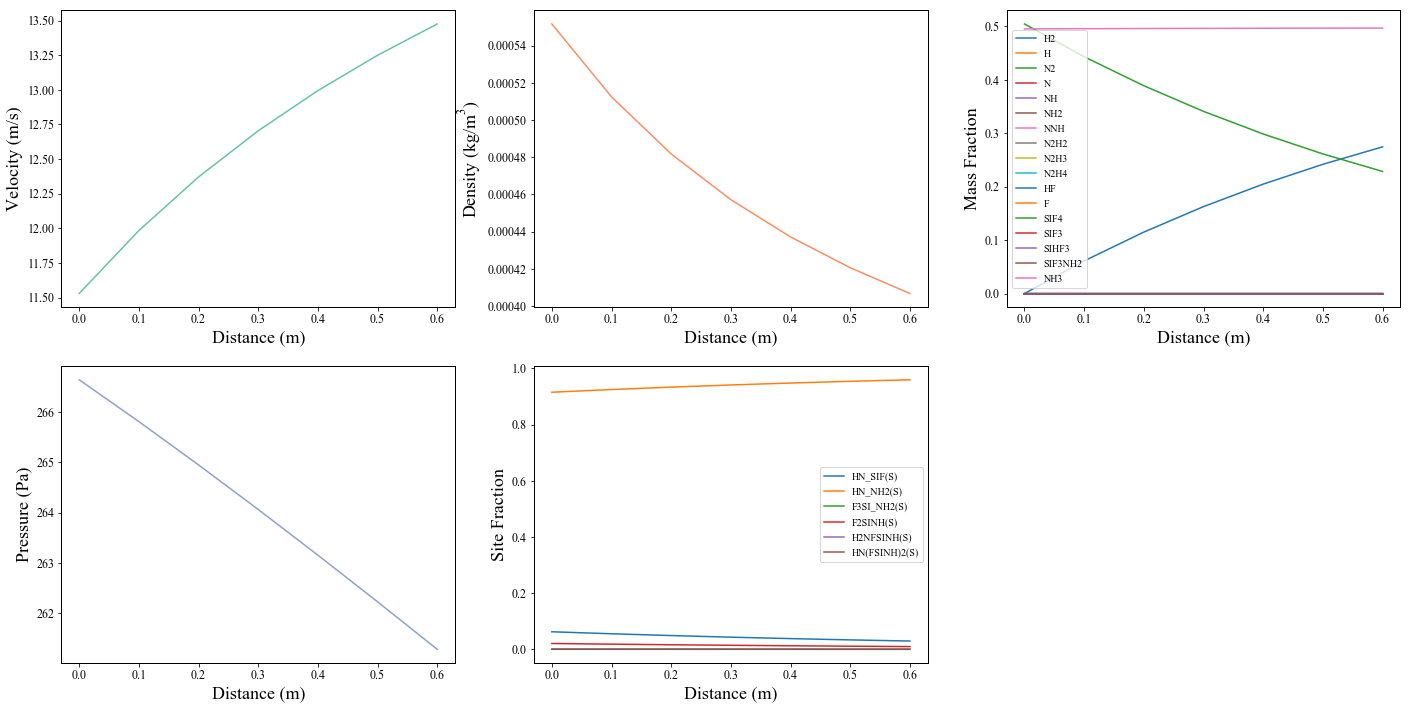

In [16]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize = (24,12))
plt.subplot(2,3,1)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,0],color = colors[0])
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')

plt.subplot(2,3,2)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,1],color = colors[1])
plt.xlabel('Distance (m)')
#plt.ylabel(Density r'$ (kg/m^3)$'')
plt.ylabel('Density ($\mathregular{kg/m^3}$)')

plt.subplot(2,3,3)
for i,name in enumerate(gas.species_names):
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+i],label = '%s'%name)
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Mass Fraction')

plt.subplot(2,3,4)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+gas.n_species],color = colors[2])
plt.xlabel('Distance (m)')
plt.ylabel('Pressure (Pa)')

plt.subplot(2,3,5)
for i,name in enumerate(gas_Si_N_interface.species_names):
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,3+gas.n_species+i],label = '%s'%(name))
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Site Fraction')
plt.show()

# Case 2: Adiabatic reactor

Since the application of isothermal reactor is not prevalent, to further complex the model for reality use the adiabatic reator is considered. Here energy balance equation should be considered.

The heat flow rate into the system has two expressions, one is due to the heat flux qe from surroundings to the outer tube wall (whose surface area per unit length is ae) and accumulation of enthalpy in the bulk solid. The other is due to the qi is the heat flux to the gas from the inner tube wall and accumulation fo enthalpy in the surface species. The expression of energy balance equation for this problem shows as follows: 
\begin{align}
    \rho u A_c c_p \frac{dT}{dz} +A_c \sum_{K_g}\omega_k\dot{W_k}h_k + p'\sum_{K_g}h_k\dot{s_k}W_k &= a_eq_e - p'\sum^{K_b}_{bulk}\omega_kh_k\\&=p'q_i + p'\sum^{K_g}_{gas}\dot{s_k}W_kh_k
\end{align}
Since the adiabatic reactor is considered, qe = 0. Similar procedure as isothermal reactor model, adding the energy equation into the residual function and calculate the initial value of the prime of the temperature. 

In [17]:
############################### initial conditions ##################################################################
#import the SiF4 + NH3 reaction mechnism
mech ='/Users/yuanjie/Dropbox/Cantera_intern/code/gas_surf_phase/gas_surf_bulk/mec.cti'
#import the models for gas and bulk
ct.suppress_thermo_warnings()
gas, bulk_Si, bulk_N = ct.import_phases(mech,['gas','SiBulk','NBulk',])

#import the model for gas-Si-N interface
gas_Si_N_interface = ct.Interface(mech, 'SI3N4',[gas,bulk_Si,bulk_N])
T = 1713 #K
p = 2 * ct.one_atm / 760.0 #Pa ~2Torr
gas.TPX = T,p,"NH3:6, SiF4:1"
bulk_Si.TP = T,p
bulk_N.TP = T,p
gas_Si_N_interface.TP = T,p
D = 5.08 * 10**-2 #diameter of the tube [m]
Ac = np.pi * D**2/4 # cross section of the tube [m]
Vdot = 588 * 10**-6/60 # volumetric rate [m^3/s]
mu = 5.7E-5 #kg/(m s) dynamic viscosity
perim = np.pi * D #perimeter of the tube
sigma_k = [2, 2, 2, 2, 4, 2] #site fraction of surface species as the same order of CTI file
#calculate the site fractions of surface species at the entrance of the tube at steady state
gas_Si_N_interface.advance_coverages(100.0)
Zk_0 = gas_Si_N_interface.coverages
######################################## IDA solver ###################################################################
def residual(z, vec, vecp, result):
    """ we create the residual equations for the problem
        vec = [u, rho, Yk, p, Zk, T]
    """
    gas.set_unnormalized_mass_fractions(vec[2:2+gas.n_species])
    gas.TP = vec[-1],vec[2+gas.n_species]
    
    bulk_Si.TP = vec[-1],vec[2+gas.n_species]
    bulk_N.TP = vec[-1],vec[2+gas.n_species]
    gas_Si_N_interface.set_unnormalized_coverages(vec[3+gas.n_species:-1])
    gas_Si_N_interface.TP = vec[-1],vec[2+gas.n_species]
       
    #mass continuity equation
    result[0] = vec[0]*vecp[1]+vec[1]*vecp[0]-perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)/Ac
    #conservation of species
    for k in range(gas.n_species):
        result[1+k] = vec[1]*vec[0]*Ac*vecp[2+k] + vec[2+k]*perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)\
                      - gas.net_production_rates[k]*gas.molecular_weights[k]*Ac\
                      - gas_Si_N_interface.net_production_rates[k]*gas.molecular_weights[k]*perim 
    #conservation of momentum
    result[1+gas.n_species] = 2*vec[1]*vec[0]*vecp[0] + np.power(vec[0],2)*vecp[1] + vecp[2+gas.n_species] + 32*vec[0]*mu/D**2 
    #equation of state
    #result[2+gas.n_species] = vec[2+gas.n_species]*gas.mean_molecular_weight - vec[1]*ct.gas_constant*T
    result[2+gas.n_species] = gas.density - vec[1]
    #algebraic constraints
    for j in range(gas_Si_N_interface.n_species):
        result[3+gas.n_species+j] = gas_Si_N_interface.net_production_rates[-gas_Si_N_interface.n_species+j]
    #replace the constraints with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(gas_Si_N_interface.coverages)
    result[3+gas.n_species+index] = np.sum(gas_Si_N_interface.coverages) - 1
    #energy equation
    result[3+gas.n_species+gas_Si_N_interface.n_species] = vec[1]*vec[0]*Ac*gas.cp*vecp[-1]\
                                                         + Ac*np.sum(gas.net_production_rates*gas.molecular_weights*gas.enthalpy_mass)\
                                                         + perim*np.sum(gas.enthalpy_mass*gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)\
                                                         + perim*np.sum(gas_Si_N_interface.net_production_rates[gas.n_species:gas.n_species+2]*np.append(bulk_Si.molecular_weights,bulk_N.molecular_weights)*np.append(bulk_Si.enthalpy_mass,bulk_N.enthalpy_mass)) 

In [18]:
########use ling to solve the initial vecp###########
"""
   a = coefficient of [u', rho', Yk', P',T]
   b = RHS constant of each conservation equations
"""
rho0 = gas.density
u0 = 11.53 #m/s
################### a #########################
a = np.zeros((4+gas.n_species,4+gas.n_species))
a[0,:] = np.append([rho0,u0],np.zeros(2+gas.n_species))
for i in range(gas.n_species):
    a[1+i,2+i] = rho0*u0*Ac
a[1+gas.n_species,:] = np.append(np.append([2*rho0*u0, u0**2],np.zeros(gas.n_species)),[1,0])
coef = np.zeros(gas.n_species)
for j in range(gas.n_species):
    coef[j] = gas.P/gas.molecular_weights[j]/np.power(np.sum(gas.Y/gas.molecular_weights),2)
a[2+gas.n_species,:] = np.append(np.append([0,ct.gas_constant*T],coef),[-gas.mean_molecular_weight,0])
a[3+gas.n_species,:] = np.append(np.zeros(3+gas.n_species),rho0*u0*Ac*gas.cp)
################### b ###########################
b = np.zeros(4+gas.n_species)
b[0] = perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)/Ac
for i in range(gas.n_species):
    b[1+i] = gas.net_production_rates[i]*gas.molecular_weights[i]*Ac\
             + gas_Si_N_interface.net_production_rates[i]*gas.molecular_weights[i]*perim\
             - gas.Y[i]*perim*np.sum(gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights) 
b[1+gas.n_species] = -32*u0*mu/D**2
b[2+gas.n_species] = 0
b[3+gas.n_species] = - Ac*np.sum(gas.net_production_rates*gas.molecular_weights*gas.enthalpy_mass)\
                     - perim*np.sum(gas.enthalpy_mass*gas_Si_N_interface.net_production_rates[:gas.n_species]*gas.molecular_weights)\
                     - perim*np.sum(gas_Si_N_interface.net_production_rates[gas.n_species:gas.n_species+2]*np.append(bulk_Si.molecular_weights,bulk_N.molecular_weights)\
                     *np.append(bulk_Si.enthalpy_mass,bulk_N.enthalpy_mass))
part_vecp0 = np.linalg.solve(a,b)
vecp0 = np.append(np.append(part_vecp0[:-1],np.zeros(gas_Si_N_interface.n_species)),part_vecp0[-1])

In [19]:
solver = dae('ida', residual, 
             #compute_initcond='yp0', #If yp0, then the differential variables (y of the ode system at time 0) will be used to solve for the derivatives of the differential variables, so yp0 will be calculated
             first_step_size=1e-18,
             atol=1e-8, #absolute tolerance for solution
             rtol=1e-8, #relative tolerance for solution
             algebraic_vars_idx=[np.arange(3+gas.n_species,3+gas.n_species+gas_Si_N_interface.n_species,1)], #If the given problem is of type DAE, some items of the residual
             #algebraic_vars_idx=[19, 20, 21, 22, 23, 24],
             #vector returned by the 'resfn' have to be treated as
                    #algebraic equations, and algebraic variables must be defined.
                    #These algebraic variables are denoted by the position (index)
                    #in the state vector y.
                    #All these indexes have to be specified in the
                    #'algebraic_vars_idx' array.
             #compute_initcond_t0 = 60,#When calculating the initial condition, specifies the time
                                      # until which the solver tries to
                                      #get the consistent values for either y0 or yp0 relative to
                                      #the starting time. Positive if t1 > t0, negative if t1 < t0
             max_steps=500000,
             old_api=False)#Forces use of old api (tuple of 7) if True or
                    #new api (namedtuple) if False.
                    #Other options may require new api, hence using this should
                    #be avoided if possible.

vec0 = np.append(np.append(np.append(np.append([11.53, gas.density], gas.Y),gas.P),Zk_0),T)
solution = solver.solve(np.arange(0,0.7,0.1), vec0,vecp0)
solution

SolverReturn(flag=0, values=SolverVariables(t=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), y=array([[ 1.15300000e+01,  5.51650066e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.04595486e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.95404514e-01,  2.66644737e+02,  6.25700848e-02,
         9.15541628e-01,  3.14167985e-04,  2.08511788e-02,
         2.40980048e-04,  4.81960097e-04,  1.71300000e+03],
       [ 1.12003862e+01,  5.48019431e-04,  1.75761960e-07,
         1.86606187e-10,  3.61617083e-10,  1.02451310e-14,
         2.15801334e-10,  2.79367466e-06,  1.02797304e-11,
         7.22193345e-10,  2.60768004e-11,  1.63963252e-12,
         6.20348765e-02,  8.31814694e-12,  4.42205361e-01,
         6.26688685e-11,  9.12829346e-11,  5.76435218e-10,
         4.95756791e-0

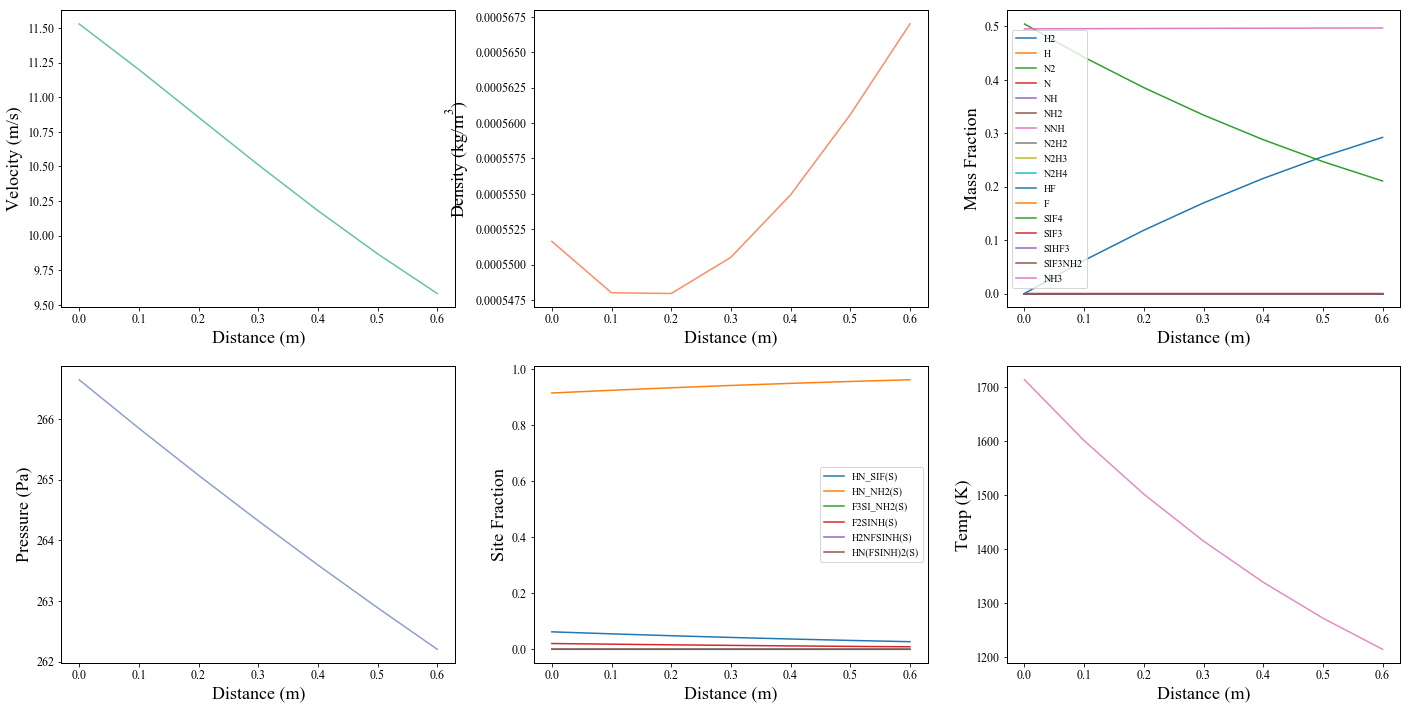

In [20]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize = (24,12))
plt.subplot(2,3,1)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,0],color = colors[0])
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')

plt.subplot(2,3,2)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,1],color = colors[1])
plt.xlabel('Distance (m)')
#plt.ylabel(Density r'$ (kg/m^3)$'')
plt.ylabel('Density ($\mathregular{kg/m^3}$)')

plt.subplot(2,3,3)
for i,name in enumerate(gas.species_names):
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+i],label = '%s'%name)
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Mass Fraction')

plt.subplot(2,3,4)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+gas.n_species],color = colors[2])
plt.xlabel('Distance (m)')
plt.ylabel('Pressure (Pa)')

plt.subplot(2,3,5)
for i,name in enumerate(gas_Si_N_interface.species_names):
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,3+gas.n_species+i],label = '%s'%(name))
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Site Fraction')

plt.subplot(2,3,6)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,-1],color = colors[3])
plt.xlabel('Distance (m)')
plt.ylabel('Temp (K)')
plt.show()